# Blue and green deployments with HAProxy
This tutorial demonstrates how to configure blue/green deployment on HAProxy Ingress controller, in order to route requests based on distict weight on deployment groups as well as selecting a group based on version types of eclwatch.

Blue-green deployments avoid having two versions at play at the same time by swapping one set of pods for another.

## Prerequisites
* A running kubernetes cluster with the HAProxy controller deployed

## Prepare values.yaml

Add the 2 eclwatches under the esp section in the hpcc/values.yaml file that is used when deploying HPCC, they are called blue and green.  

* Note: In the file, certificates enabled: is false.

Set one of them to a different version, for example green is set to version 8.2.2-1. The rest will use version 8.2.4. Add tolerations if using Spot Instance.

To add the tolerations to the hpcc/values.yaml file if using spot instances:

In [ ]:
placements:
- pods: ["all"]
  placement:
    tolerations:
    - key: "kubernetes.azure.com/scalesetpriority"
      operator: "Equal"
      value: "spot"
      effect: "NoSchedule"

1) Delete the eclwatch previously defined in this file, and the data defined in it.

2) Add the following eclwatches to the esp:

In [ ]:
esp:
- name: blue
  ## Pre-configured esp applications include eclwatch, eclservices, and eclqueries
  application: eclwatch
  auth: none
  replicas: 1
  labels:
    tag: bluegreen
    group: blue
  service:
    port: 8888
    servicePort: 8010
    visibility: global

- name: green
  image:
    root: "hpccsystems"
    name: platform-core
    version: 8.2.2-1
  ## Pre-configured esp applications include eclwatch, eclservices, and eclqueries
  application: eclwatch
  auth: none
  replicas: 1
  labels:
    tag: bluegreen
    group: green
  service:
    ## port can be used to change the local port used by the pod. If omitted, the default port (8880) is used
    port: 8888
    ## servicePort controls the port that this service will be exposed on, either internally to the cluster, or externally
    servicePort: 8010
    ## Specify visibility: local (or global) if you want the service available from outside the cluster. Typically, eclwatch and wsecl are published externally,$
    visibility: global

## Deploy the HPCC Helm chart
After preparing the hpcc/values.yaml file, deploy the HPCC cluster as:

In [ ]:
helm install hpcc hpcc/ --set global.image.version=8.2.4 -f examples/azure/values-auto-azurefile.yaml

You should see something like this:

In [ ]:
NAME: hpcc
LAST DEPLOYED: Mon Aug  2 15:34:42 2021
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
Thank you for installing the HPCC chart version 8.2.4 using image "hpccsystems/platform-core:8.2.4"


**** WARNING: The configuration contains ephemeral planes: [dali dll sasha data mydropzone] ****

This chart has defined the following HPCC components:
  dali.mydali
  dfuserver.dfuserver
  eclagent.hthor
  eclagent.roxie-workunit
  eclccserver.myeclccserver
  eclscheduler.eclscheduler
  esp.eclwatch
  esp.eclservices
  esp.eclqueries
  esp.esdl-sandbox
  esp.sql2ecl
  roxie.roxie
  thor.thor
  sasha.dfurecovery-archiver
  sasha.dfuwu-archiver
  sasha.file-expiry
  sasha.wu-archiver

Use ```kubectl get pod``` to make sure all pods are running.

## Verify versions of the two eclwatch
Get IPs of the two eclwatch services, blue and green:

In [ ]:
kubectl get svc

You should see the services blue and green:

In [ ]:
NAME                   TYPE           CLUSTER-IP     EXTERNAL-IP     PORT(S)                      AGE
blue                   LoadBalancer   10.0.156.130   20.94.33.65     8010:31661/TCP               2m44s
green                  LoadBalancer   10.0.156.123   20.94.33.36     8010:32286/TCP               2m44s

Confirm that these services map to their specified version.  Service green should be version 8.2.2-1, the old version, and version 8.2.4-1, the new version, should be mapped to service blue.

To verify this is true, visit the external ip followed by port :8010, such as 

try service blue:

http://20.94.33.65:8010

Click the top right corner with three bars, click **about**, and make sure the version says 8.2.4-1.

You should see something like this:

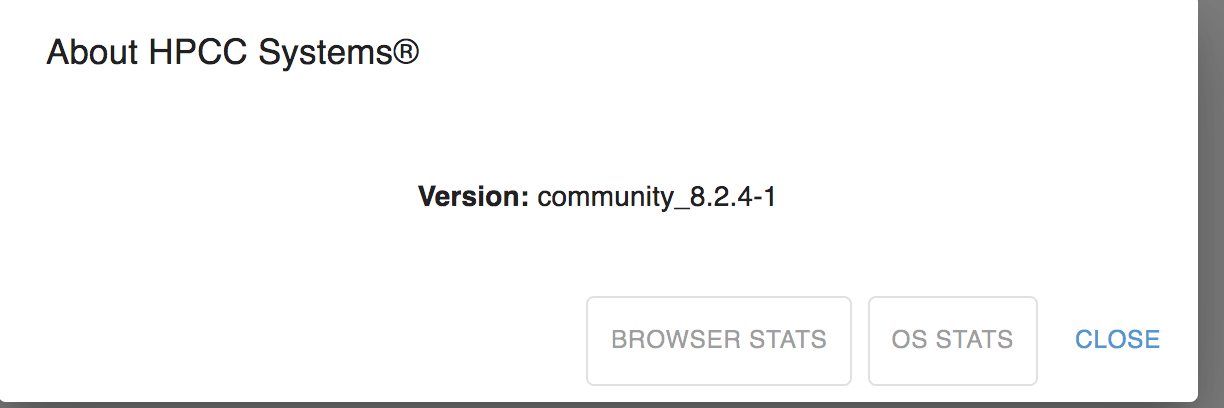

Now try service green, for example:

http://20.94.33.36:8010

Click the top right corner with three bars, click about, and make sure the version says 8.2.2-1.

You should see something like this:

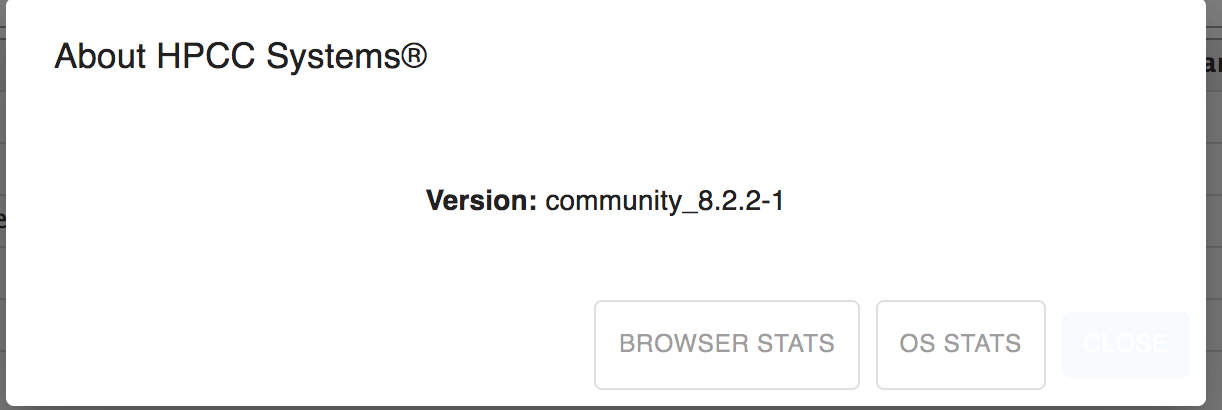

## Replace two eclwatch services with the new one
Both services blue and green are tagged as "bluegreen".  You can use a common service to map to either service blue or green. 

1) Delete the services

Delete the service blue:

In [ ]:
kubectl delete svc blue

You should see something like this:

In [ ]:
service "blue" deleted

Delete the service green:

In [ ]:
kubectl delete svc green

You should see something like this:

In [ ]:
service "green" deleted

You can run ```kubectl get svc``` to confirm that blue and green are no longer there.

2) Create a new service that bind both deployments together, open a file, such as **eclwatch.yaml**, and copy in the following:

In [ ]:
 Source: hpcc/templates/esp.yaml
apiVersion: v1
kind: Service
metadata:
  name: "bluegreen"
spec:
  ports:
  - port: 8010
    protocol: TCP
    targetPort: 8888
  selector:
    #server: "blue"
    tag: bluegreen
  type: ClusterIP

Apply this file:

In [ ]:
kubectl apply -f eclwatch.yaml

You should see something like this:

In [ ]:
service/bluegreen created

The tag bluegreen is applied, so both blue and green services can be mapped to.  This file specifies clusterIP, so it is not accessible externally yet.  That is why an ingress file is needed, created in the next step.

## Create an Ingress
Create an ingress file to route traffic to both services blue and green, such as **bluegreen-ingress.yaml**:

The new version 8.2.4 is assigned to group blue, and the rest of traffic will go to the old version, green (8.2.2).  The ratio is 4:1, blue:green.  This means four times more requests will be sent to the new version.

* Note: for both services to each have 50% of traffic, use 1:1 ratio.

In [ ]:
apiVersion: networking.k8s.io/v1beta1
kind: Ingress
metadata:
  annotations:
    kubernetes.io/ingress.class: haproxy
    ingress.kubernetes.io/balance-algorithm: roundrobin
    ingress.kubernetes.io/blue-green-deploy: group=blue=4,group=green=1
    ingress.kubernetes.io/blue-green-mode: Deployment
    ingress.kubernetes.io/ssl-redirect: "false"
  name: bluegreen
spec:
  rules:
  - http:
      paths:
      - backend:
          serviceName: bluegreen
          servicePort: 8010
        path: /
        # - host: bluegreen.52.232.213.165.nip.io

Apply the ingress file:

In [ ]:
kubectl apply -f bluegreen-ingress.yaml

You should see something like this:

In [ ]:
ingress.networking.k8s.io/bluegreen created

Next, verify the ingress:

In [ ]:
kubectl get ingress

You should see that the ingress "bluegreen" is created:

In [ ]:
NAME        CLASS    HOSTS   ADDRESS   PORTS   AGE
bluegreen   <none>   *                 80      13s

## Test the configuration
Get IP for HAProxy Ingress controller to test the blue/green deployment:

In [ ]:
kubectl get svc

You should see something like this:

In [ ]:
NAME                   TYPE           CLUSTER-IP     EXTERNAL-IP     PORT(S)                      AGE
haproxy-ingress        LoadBalancer   10.0.237.73    20.96.116.150   80:31416/TCP,443:32230/TCP   3h22m

Next, go to a web browser, enter the external IP.  The eclwatch website will be shown.  Then, check the version in the "about" section of the settings in the upper right corner.

Refresh the browser, checking the version number after each time.  After a random number of refreshes, a different version should be shown.

The new version as shown will be seen most of the times, since the ratio was 4, to 1, the old version.

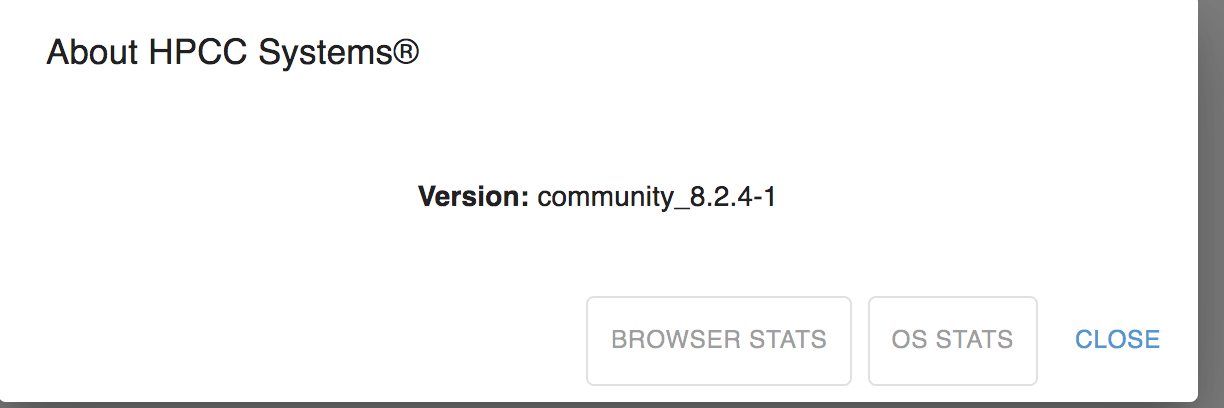

After many refreshes of the web browser, the older version, mapped to group green, will be shown:

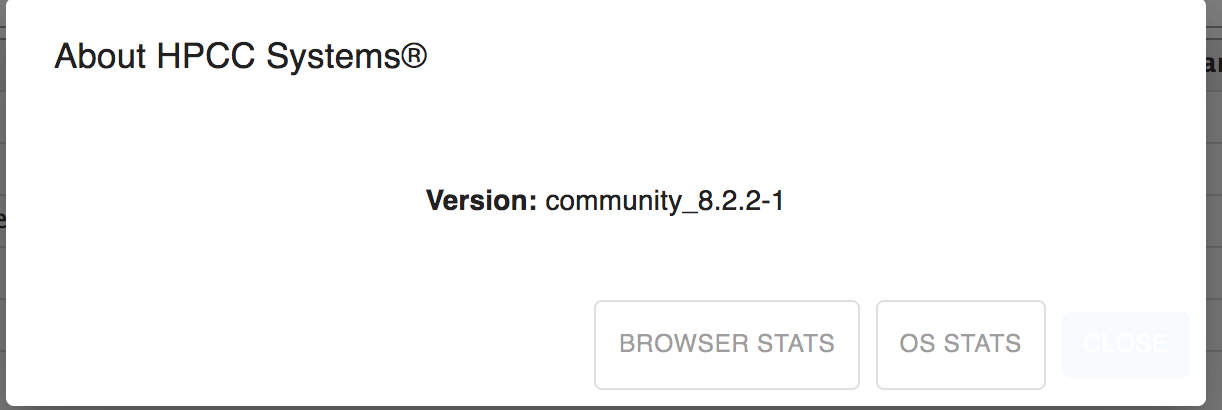

# Cleanup

1) Delete the service:

In [ ]:
kubectl delete svc bluegreen 

You should see something like this:

In [ ]:
service "bluegreen" deleted

2) Delete the HAProxy controller, specify a namespace if applicable:

In [ ]:
helm delete haproxy-ingress 

You should see something like this:

In [ ]:
release "haproxy-ingress" uninstalled

3) Delete the hpcc helm chart:

In [ ]:
helm delete hpcc

You should see something like this:

In [ ]:
release "hpcc" uninstalled

4) Delete the ingress:

In [ ]:
kubectl delete ingress bluegreen

You should see something like this:

In [ ]:
ingress.extensions "bluegreen" deleted